# Google Colab

In [239]:
Google_Colab = True

In [240]:
import os

if Google_Colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  os.chdir("/content/gdrive/My Drive/FPL_ML")
else:
  os.chdir("D:\PulpitE\FPL_ML")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [241]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [242]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [243]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [244]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [245]:
df = pd.read_csv('data/final_dataset.csv')

In [246]:
# remembering original df
df_original = df

In [247]:
# df.iloc[1]

In [248]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [249]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [250]:
df.shape

(7457, 13)

In [251]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [252]:
df.shape

(5771, 13)

In [253]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,1,MID,83.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,2.0,0.0,0.1,0.1,0.1,0.0,0.0,2.0
2,Brenden-Aaronson,3,MID,82.0,1.0,2.0,2.0,1.0,1.0,0.1,1.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
8,Brenden-Aaronson,11,MID,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0


In [254]:
last_names = df["Name"].unique()

In [255]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Sh', 'SoT', 'xG', 'npxG',
       'xAG', 'CS', 'Was Home', 'FPL'],
      dtype='object')

In [256]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [257]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [258]:
df.shape

(5771, 13)

In [259]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [260]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [261]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [262]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [263]:
dataset.__getitem__(0)

(array([[83. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.1,  0. ,  0. ],
        [82. ,  1. ,  2. ,  2. ,  1. ,  1. ,  0.1,  1. ,  1. ],
        [81. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [75. ,  0. ,  1. ,  1. ,  0.1,  0.1,  0.1,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.3,  0. ,  0. ],
        [78. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  1. ,  1. ],
        [75. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ]],
       dtype=float32), 2.0)

In [264]:
dataset_fwd.__getitem__(10)

(array([[90. ,  1. ,  2. ,  1. ,  0.4,  0.4,  0. ,  1. ,  0. ],
        [18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  5. ,  2. ,  0.7,  0.7,  0.1,  0. ,  0. ],
        [63. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [90. ,  1. ,  3. ,  2. ,  0.6,  0.6,  0.2,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [90. ,  0. ,  3. ,  1. ,  0.4,  0.4,  0.1,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ]],
       dtype=float32), 5.0)

In [265]:
dataset_gk.__len__()

305

In [266]:
dataset_def.__len__()

1137

In [267]:
dataset_mid.__len__()

1469

In [268]:
dataset_fwd.__len__()

356

In [269]:
batch_size = 16

In [270]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [271]:
# next(iter(dataloader_mid))

In [272]:
# next(iter(dataloader))[1]

# LSTM Model

In [273]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [274]:
len(dataloader)

205

# Training loops

In [275]:
criterion = nn.MSELoss()

In [276]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [277]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [278]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 3.8086094031973583
Epoch 5 Loss: 3.112230688042757
Epoch 10 Loss: 3.044052117554153
Epoch 15 Loss: 3.0449233567569314
Epoch 20 Loss: 3.018303294225437
Epoch 25 Loss: 2.983998137857856
CPU times: user 3min 34s, sys: 3.08 s, total: 3min 37s
Wall time: 3min 34s


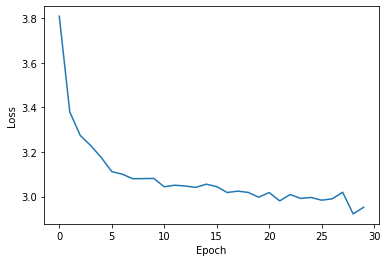

In [279]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [280]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [281]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 50, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 1.5261951819062234
Epoch 5 Loss: 0.5005408203229308
Epoch 10 Loss: 0.4995914719067514
Epoch 15 Loss: 0.4760818863287568
Epoch 20 Loss: 0.3475758470594883
Epoch 25 Loss: 0.3327324457466602
Epoch 30 Loss: 0.3251340601593256
Epoch 35 Loss: 0.33322702571749685
Epoch 40 Loss: 0.3211747944355011
Epoch 45 Loss: 0.3202524401247501
CPU times: user 22.3 s, sys: 318 ms, total: 22.6 s
Wall time: 22.3 s


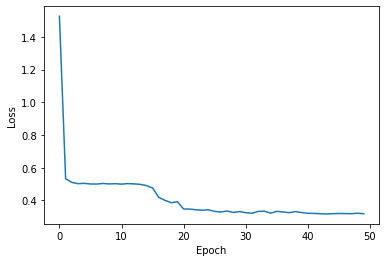

In [282]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [283]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [284]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 50, dataloader_def, optimizer_def)

Epoch 0 Loss: 1.6795817590836022
Epoch 5 Loss: 1.211041608825326
Epoch 10 Loss: 1.1885599030388727
Epoch 15 Loss: 1.1564024252196152
Epoch 20 Loss: 1.1389892401380672
Epoch 25 Loss: 1.1457157902833488
Epoch 30 Loss: 1.1484155224429236
Epoch 35 Loss: 1.1439102381053898
Epoch 40 Loss: 1.17921181788875
Epoch 45 Loss: 1.1277037442972262
CPU times: user 1min 34s, sys: 1.34 s, total: 1min 35s
Wall time: 1min 34s


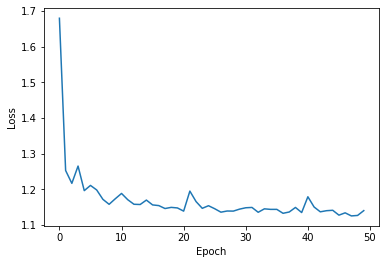

In [285]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [286]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [287]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 50, dataloader_mid, optimizer_mid)

Epoch 0 Loss: 5.2645240908731585
Epoch 5 Loss: 4.283682623311229
Epoch 10 Loss: 4.094497727635114
Epoch 15 Loss: 4.085916289492793
Epoch 20 Loss: 3.9942252823840017
Epoch 25 Loss: 3.9573918736499287
Epoch 30 Loss: 4.012703385366046
Epoch 35 Loss: 3.954718825933726
Epoch 40 Loss: 4.083833393195401
Epoch 45 Loss: 4.064231680463189
CPU times: user 2min 8s, sys: 1.69 s, total: 2min 9s
Wall time: 2min 8s


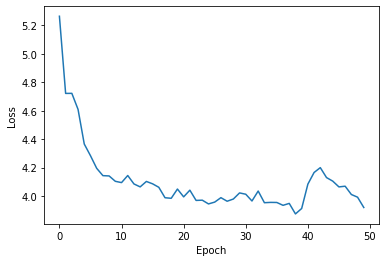

In [288]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [289]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [290]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 100, dataloader_fwd, optimizer_fwd)

Epoch 0 Loss: 12.559880342172539
Epoch 5 Loss: 8.367691060771113
Epoch 10 Loss: 8.33304444603298
Epoch 15 Loss: 8.370661543763202
Epoch 20 Loss: 7.932065621666286
Epoch 25 Loss: 7.352515906419443
Epoch 30 Loss: 6.9373960896678595
Epoch 35 Loss: 7.453712186087733
Epoch 40 Loss: 6.820499541966812
Epoch 45 Loss: 6.542818094725194
Epoch 50 Loss: 6.458823696102785
Epoch 55 Loss: 6.287019304607226
Epoch 60 Loss: 6.364030006139175
Epoch 65 Loss: 6.282938288605732
Epoch 70 Loss: 6.168752746089645
Epoch 75 Loss: 6.2107598962991135
Epoch 80 Loss: 5.854754966886147
Epoch 85 Loss: 6.108832884741866
Epoch 90 Loss: 6.206049245984658
Epoch 95 Loss: 6.315007132032643
CPU times: user 52.2 s, sys: 661 ms, total: 52.9 s
Wall time: 52.1 s


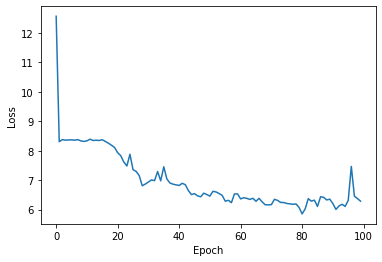

In [291]:
plot_loss_history(loss_history_fwd)

# Saving models to files

In [318]:
torch.save(net.state_dict(), 'models/lstm_general.pt')

torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [301]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            gw = sample_id + FIS + 1
            predictions_pos.append([name, gw, points])
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    return predictions_pos

In [303]:
predictions = generate_predictions(dataloader, dataset, net)

In [298]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1555,Harry-Kane,18,6.55
1298,Erling-Haaland,19,6.51
2919,Ivan-Toney,18,6.48
1295,Erling-Haaland,16,6.43
1548,Harry-Kane,11,6.42
1288,Erling-Haaland,9,6.37
2915,Ivan-Toney,14,6.33
3260,Martin-Odegaard,12,6.32
2085,Aleksandar-Mitrovic,17,6.28
2404,Marcus-Rashford,18,6.26


In [304]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [297]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [306]:
predictions_gk = generate_predictions(dataloader_gk, dataset_gk, net_gk)

In [307]:
# results sorted
pd.DataFrame(predictions_gk, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
277,Robert-Sanchez,16,2.37
119,Dean-Henderson,11,2.37
168,Emiliano-Martinez,12,2.37
172,Emiliano-Martinez,16,2.37
176,Illan-Meslier,9,2.37
79,Lukasz-Fabianski,20,2.37
268,Jose-Sa,19,2.37
111,Vicente-Guaita,15,2.37
235,David-Raya,11,2.37
273,Robert-Sanchez,12,2.37


## Defenders

In [308]:
predictions_def = generate_predictions(dataloader_def, dataset_def, net_def)

In [309]:
# results sorted
pd.DataFrame(predictions_def, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1068,Adam-Webster,13,2.47
128,Dan-Burn,15,2.47
109,Sven-Botman,16,2.46
297,Ben-Davies,16,2.46
520,Ezri-Konsa,18,2.46
120,Hugo-Bueno,15,2.46
327,Issa-Diop,14,2.46
847,Marcos-Senesi,19,2.46
842,Marcos-Senesi,14,2.46
560,Clement-Lenglet,17,2.46


## Midfielders

In [310]:
predictions_mid = generate_predictions(dataloader_mid, dataset_mid, net_mid)

In [311]:
# results sorted
pd.DataFrame(predictions_mid, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1242,Rodrigo,11,5.62
1185,Marcus-Rashford,19,5.60
470,Phil-Foden,10,5.59
923,Martinelli,18,5.54
1184,Marcus-Rashford,18,5.51
1186,Marcus-Rashford,20,5.50
1269,Mohamed-Salah,17,5.47
299,Kevin-De-Bruyne,9,5.45
590,Demarai-Gray,20,5.45
1467,Martin-Odegaard,17,5.45


## Forwards

In [312]:
predictions_fwd = generate_predictions(dataloader_fwd, dataset_fwd, net_fwd)

In [313]:
# results sorted
pd.DataFrame(predictions_fwd, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
107,Erling-Haaland,10,6.56
106,Erling-Haaland,9,6.53
110,Erling-Haaland,13,6.51
109,Erling-Haaland,12,6.44
108,Erling-Haaland,11,6.40
259,Gianluca-Scamacca,15,6.33
329,Ollie-Watkins,19,6.32
113,Erling-Haaland,16,6.30
2,Che-Adams,11,6.26
337,Callum-Wilson,9,6.17
